In [10]:
# Setup cell
# Make sure to install libraries.
# To regenerate, run the scripts noted in the XXX cells

import pandas as pd
import matplotlib.pyplot as plt

# XXX Run brownie run scripts/plot_user_health.py to generate new and replace here
wsteth_file =   'scripts/data/user_losses_2023-08-21_08-46-21.csv'
wbtc_file =     'scripts/data/user_losses_2023-08-21_16-03-11.csv'
sfrxeth_file =  'scripts/data/user_losses_2023-08-21_20-43-38.csv'
weth_file =     'scripts/data/user_losses_2023-08-21_21-27-27.csv'

# List of files and corresponding markets
files_and_markets = [
    (wsteth_file, 'wsteth'),
    (wbtc_file, 'wbtc'),
    (sfrxeth_file, 'sfrxeth'),
    (weth_file, 'weth'),
]

# Function to read file and add market column
def read_file_add_market(filename, market):
    df = pd.read_csv(filename)
    df['Market'] = market
    print(df.shape)
    return df

# Read the first file to get the column names
first_file, first_market = files_and_markets[0]
master_df = read_file_add_market(first_file, first_market)
columns = master_df.columns

# Read remaining files and concatenate
for file, market in files_and_markets[1:]:
    # Read the file and add the market column
    df = read_file_add_market(file, market)

    # Sanity check for same columns
    if not df.columns.equals(columns):
        raise ValueError(f"Columns in {file} do not match columns in {first_file}")

    # Concatenate to the master DataFrame
    master_df = pd.concat([master_df, df], ignore_index=True)

# Creating an empty DataFrame to store the market names and corresponding SoftLiqPct
soft_liq_df = pd.DataFrame(columns=['Market', 'SoftLiqPct'])

# Read the CSV file containing the prices
# XXX Copy timestamps into file and run `brownie run rip_prices --network mainnet-fork-alchemy` to generate
price_df = pd.read_csv('scripts/data/prices.csv')
price_df.rename(columns={col: col + '_price' if col != 'Time' else col for col in price_df.columns}, inplace=True)

for col in price_df.columns:
    if col != 'Time':
        price_df[col] = price_df[col].astype('float') / 10 ** 18

# Merge the price DataFrame with your existing DataFrame on the 'Time' column
master_df = pd.merge(master_df, price_df, on='Time', how='left')


# Read the CSV file containing the nloans
# XXX Copy timestamps into file and run `brownie run rip_prices --network mainnet-fork-alchemy` to generate
nloans_df = pd.read_csv('scripts/data/nloans.csv')
nloans_df.rename(columns={col: col + '_nloans' if col != 'Time' else col for col in nloans_df.columns}, inplace=True)

for col in nloans_df.columns:
    if col != 'Time':
        nloans_df[col] = nloans_df[col].astype('float') 

# Merge the price DataFrame with your existing DataFrame on the 'Time' column
master_df = pd.merge(master_df, nloans_df, on='Time', how='left')


master_df.shape
master_df.groupby('Market').describe().T

(20355, 12)
(4691, 12)
(9397, 12)
(2923, 12)


Market                  sfrxeth          wbtc          weth        wsteth
Time        count  9.397000e+03  4.691000e+03  2.923000e+03  2.035500e+04
            mean   1.767294e+07  1.756100e+07  1.756037e+07  1.762694e+07
            std    1.523825e+05  9.556237e+04  9.805828e+04  1.362347e+05
            min    1.743222e+07  1.743222e+07  1.743222e+07  1.743222e+07
            25%    1.754029e+07  1.748074e+07  1.747549e+07  1.750728e+07
...                         ...           ...           ...           ...
weth_nloans min    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
            25%    2.900000e+01  1.800000e+01  1.800000e+01  2.400000e+01
            50%    4.300000e+01  2.700000e+01  2.700000e+01  3.200000e+01
            75%    6.700000e+01  3.200000e+01  3.300000e+01  5.700000e+01
            max    9.600000e+01  6.800000e+01  6.800000e+01  9.500000e+01

[112 rows x 4 columns]

[1499, 1514, 5303, 7066, 9043, 10356, 11094, 12591, 12595, 12603, 16830, 17565, 17746, 17992, 18540, 18869, 19692, 22299, 25568, 25571, 25580, 25618, 25640, 27764, 27826, 28850]


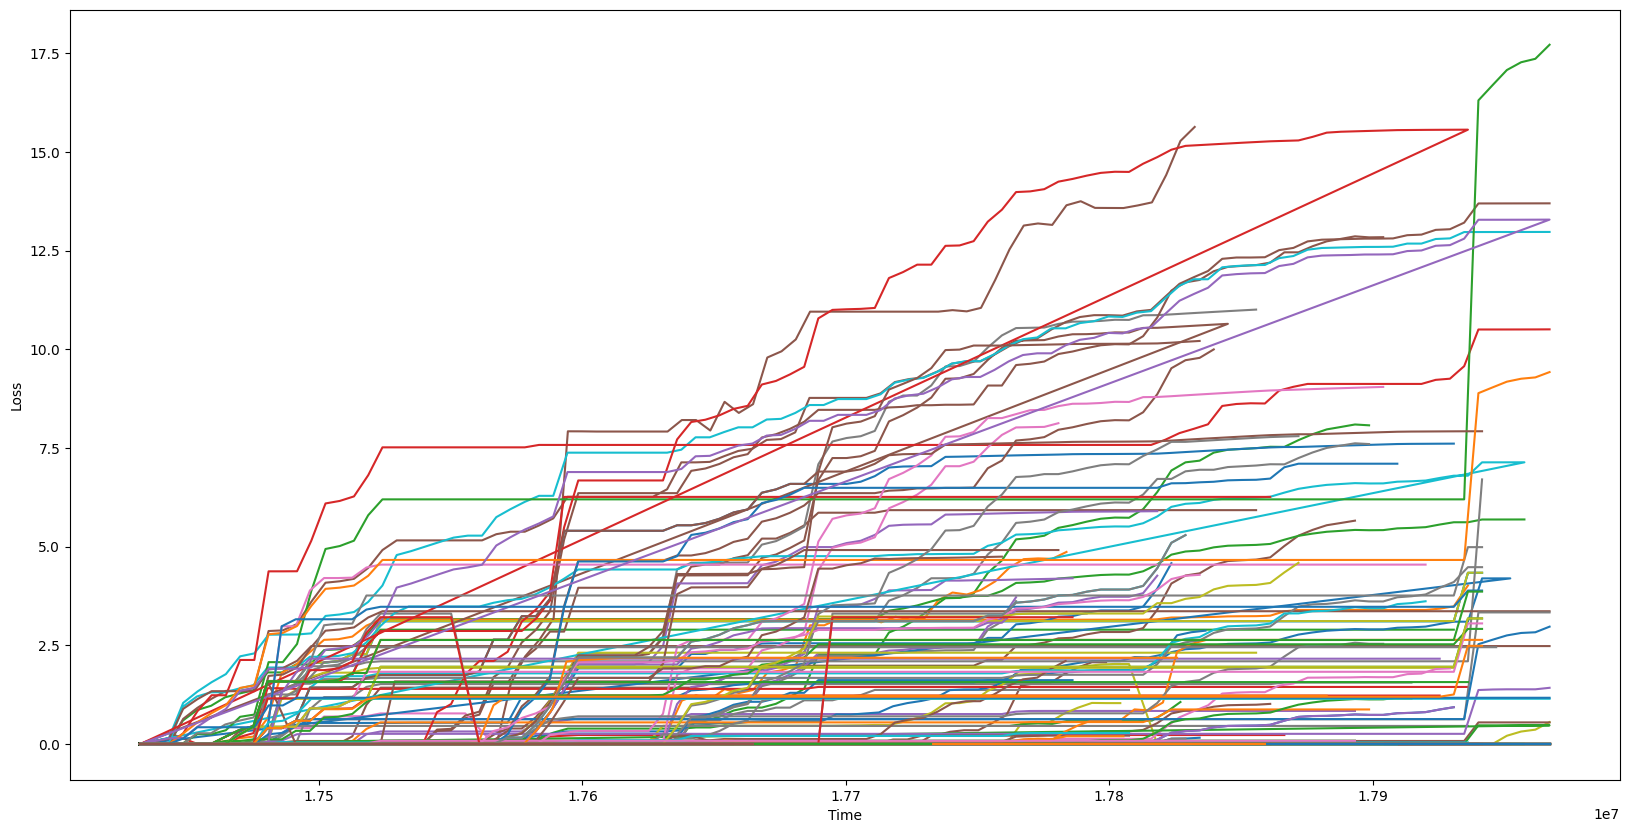

In [11]:
def find_suspicious_rows(df):
    suspicious_indices = []
    previous_loss = None
    zero_loss_index = None  # Initialize this variable outside the loop
    previous_user = None
    
    for i, row in df.iterrows():
        current_loss = row['Loss']
        current_user = row['User']
        
        if previous_loss is not None and previous_user == current_user:
            if previous_loss != 0 and current_loss == 0:
                zero_loss_index = i
            elif zero_loss_index is not None and current_loss != 0:  # Check if zero_loss_index is not None
                suspicious_indices.append(zero_loss_index)
                zero_loss_index = None
        
        previous_loss = current_loss
        previous_user = current_user
        
    return suspicious_indices

# Finding the indices of suspicious rows
suspicious_indices = find_suspicious_rows(master_df)
print(suspicious_indices)

# Dropping the suspicious rows by their indices
master_df = master_df.drop(suspicious_indices)

plt.figure(figsize=(20, 10))

# Group the DataFrame by 'User' and iterate through groups
for user, group_data in master_df.groupby('User'):
    plt.plot(group_data['Time'], group_data['Loss'], label=user)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()


/var/folders/ks/v3jy73dd6858xhmrrkj65b200000gn/T/ipykernel_2625/2324313089.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  number_of_loans = nloans_df[(nloans_df['Market'] == market) & (master_df['Time'] == max_timestamp)][f'{market}_nloans'].iloc[0]
/var/folders/ks/v3jy73dd6858xhmrrkj65b200000gn/T/ipykernel_2625/2324313089.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  number_of_loans = nloans_df[(nloans_df['Market'] == market) & (master_df['Time'] == max_timestamp)][f'{market}_nloans'].iloc[0]
/var/folders/ks/v3jy73dd6858xhmrrkj65b200000gn/T/ipykernel_2625/2324313089.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  number_of_loans = nloans_df[(nloans_df['Market'] == market) & (master_df['Time'] == max_timestamp)][f'{market}_nloans'].iloc[0]
/var/folders/ks/v3jy73dd6858xhmrrkj65b200000gn/T/ipykernel_2625/2324313089.py:14: UserWarning: Boolean Series key will be reindexed to m

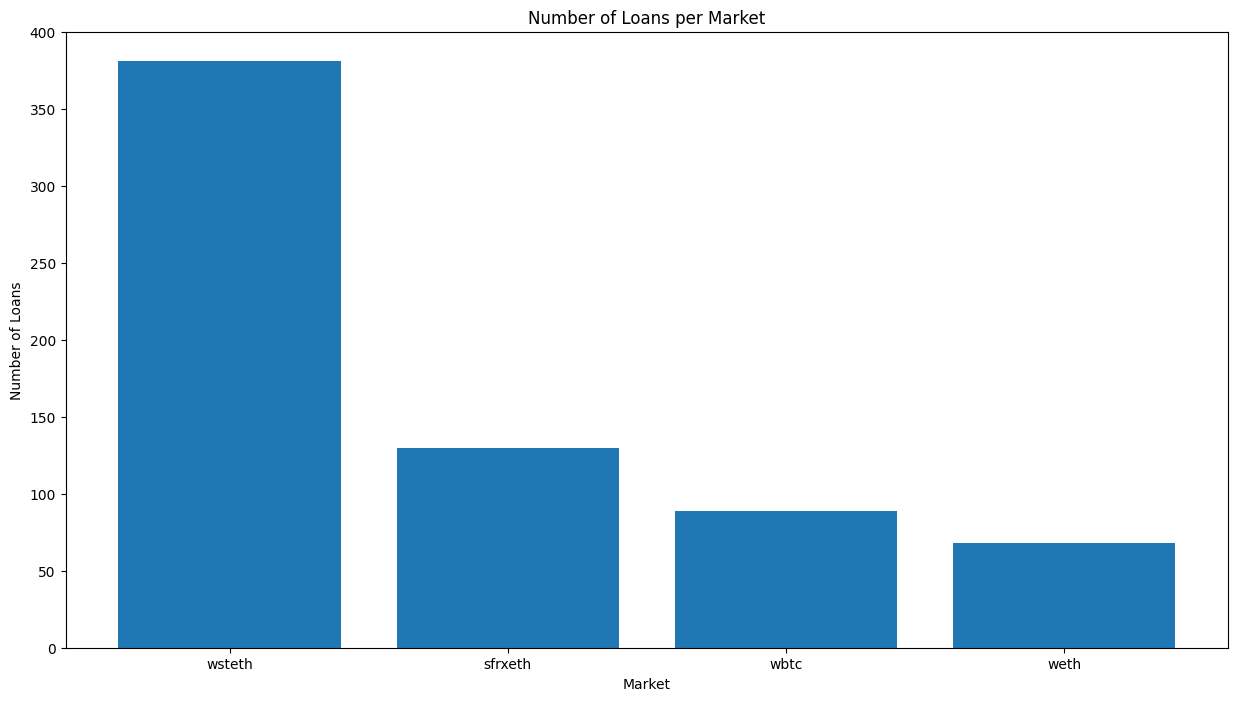

In [12]:
import matplotlib.pyplot as plt

# List of markets
markets = ['wsteth', 'sfrxeth','wbtc',  'weth']
nloans_df = master_df.dropna()
number_of_loans_list = []

# Iterate through the markets
for market in markets:
    # Get the largest timestamp for the given market
    max_timestamp = nloans_df[nloans_df['Market'] == market]['Time'].max()

    # Retrieve the corresponding number of loans
    number_of_loans = nloans_df[(nloans_df['Market'] == market) & (master_df['Time'] == max_timestamp)][f'{market}_nloans'].iloc[0]
    number_of_loans_list.append(number_of_loans)

# Plotting the bar chart
plt.figure(figsize=(15,8))
plt.bar(markets, number_of_loans_list)

plt.title('Number of Loans per Market')
plt.xlabel('Market')
plt.ylabel('Number of Loans')
plt.show()

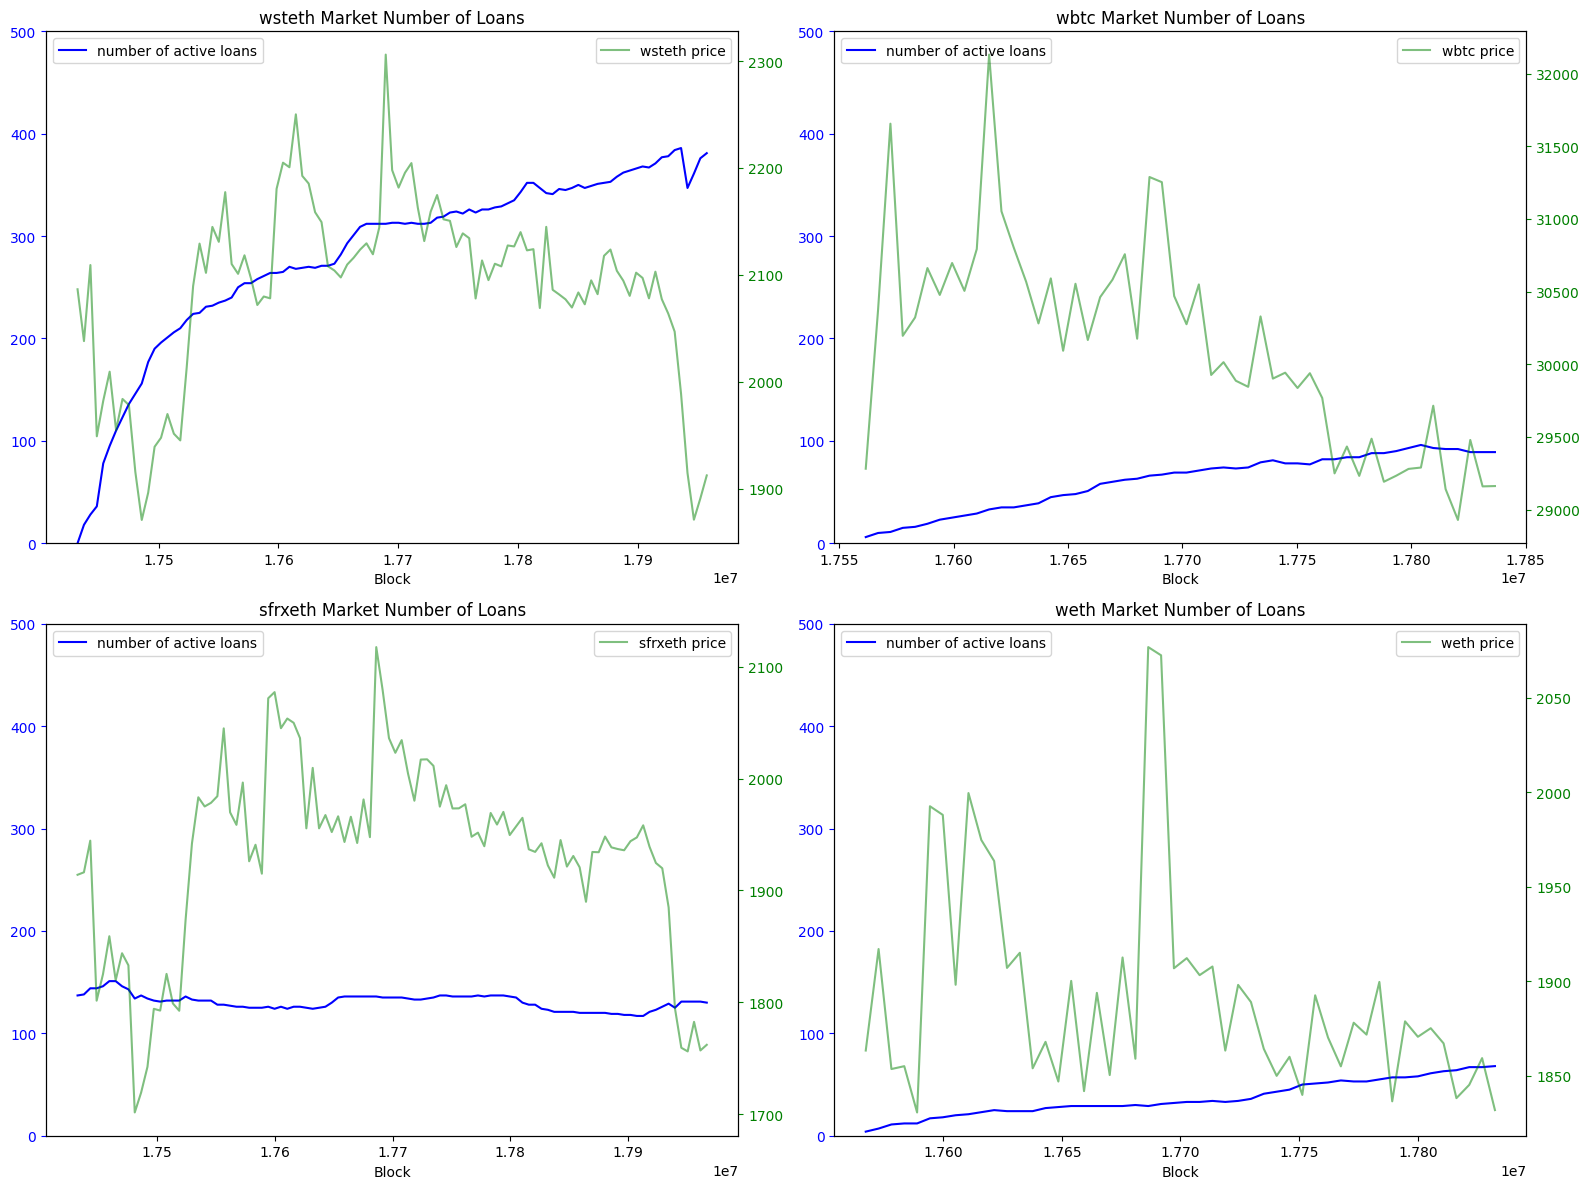

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Iterate over the markets and their respective axes
markets = ['wsteth', 'wbtc', 'sfrxeth', 'weth']
for market, ax in zip(markets, axs.flatten()):
    # Extract the market's price
    market_price = master_df[master_df['Market'] == market].sort_values('Time')  # Sorting by 'Time'

    # Assuming 'SoftLiqPct' is the column with the percentage of users who have a loss
    percentage_loss = market_price[market+'_nloans']

    # Plot the market's price as a line
    ax.plot(market_price['Time'], percentage_loss, color='blue', label='number of active loans')
    
    # Create a second y-axis
    ax2 = ax.twinx()

    # Plot the percentage of users who have a loss as a bar on the second y-axis
    ax2.plot(market_price['Time'], market_price[market+'_price'], color='green', alpha=0.5, label=f'{market} price')

    # Customize the plot
    ax.set_title(f'{market} Market Number of Loans')
    
    ax.set_xlabel('Block')
    #ax.set_ylabel('Price')
    
    #ax.set_ylabel('Number of Open Loans')
    ax.tick_params(axis='y', colors='black')
    ax.yaxis.label.set_color('black')  
    ax.set_ylim([0, 500])
    #ax2.set_ylabel(f'{market} Price')
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='green')
    ax2.yaxis.label.set_color('green')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


# Show the plots
plt.tight_layout()
plt.show()



In [14]:
min_timestamps_per_market = master_df.groupby('Market')['Time'].min()
print(min_timestamps_per_market)

max_timestamps_per_market = master_df.groupby('Market')['Time'].max()
print(max_timestamps_per_market)

Market
sfrxeth    17432225
wbtc       17432225
weth       17432225
wsteth     17432225
Name: Time, dtype: int64
Market
sfrxeth    17967166
wbtc       17836546
weth       17832443
wsteth     17957618
Name: Time, dtype: int64


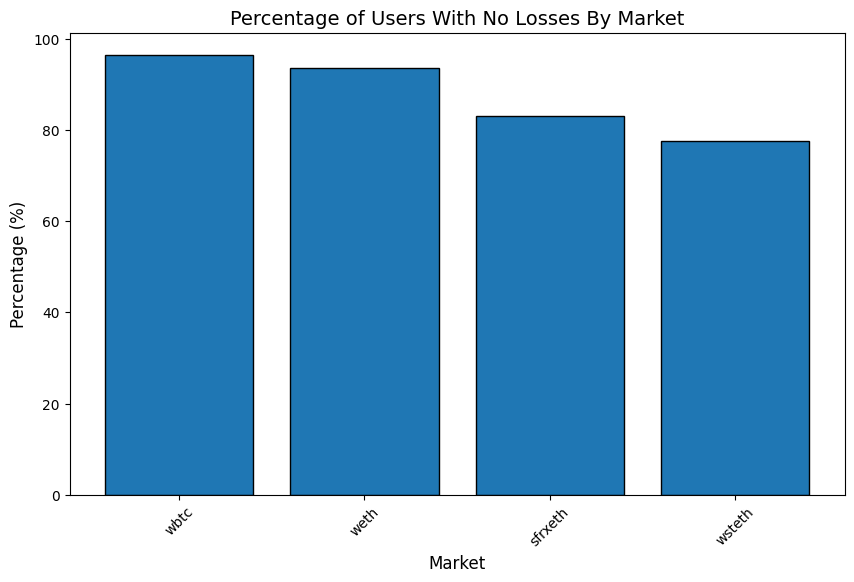

In [15]:
import matplotlib.pyplot as plt

# Creating lists to store the market names and corresponding percentages
markets = []
percentages_no_debt = []

# Iterating through the unique markets
for market in master_df['Market'].unique():
    market_df = master_df[master_df['Market'] == market]
    users_with_no_debt = market_df.groupby('User')['Loss'].max() == 0
    num_users_with_no_debt = users_with_no_debt.sum()
    total_users = market_df['User'].nunique()
    percentage_no_debt = (num_users_with_no_debt / total_users) * 100
    
    # Appending the market name and percentage to the lists
    markets.append(market)
    percentages_no_debt.append(percentage_no_debt)


# Creating a DataFrame to hold the markets and corresponding percentages
percentage_df = pd.DataFrame({
    'Market': markets,
    'Percentage_No_Debt': percentages_no_debt
})

# Sorting the DataFrame by the percentages
percentage_df = percentage_df.sort_values('Percentage_No_Debt', ascending=False)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(percentage_df['Market'], percentage_df['Percentage_No_Debt'], edgecolor='black')
plt.title('Percentage of Users With No Losses By Market', fontsize=14)
plt.xlabel('Market', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

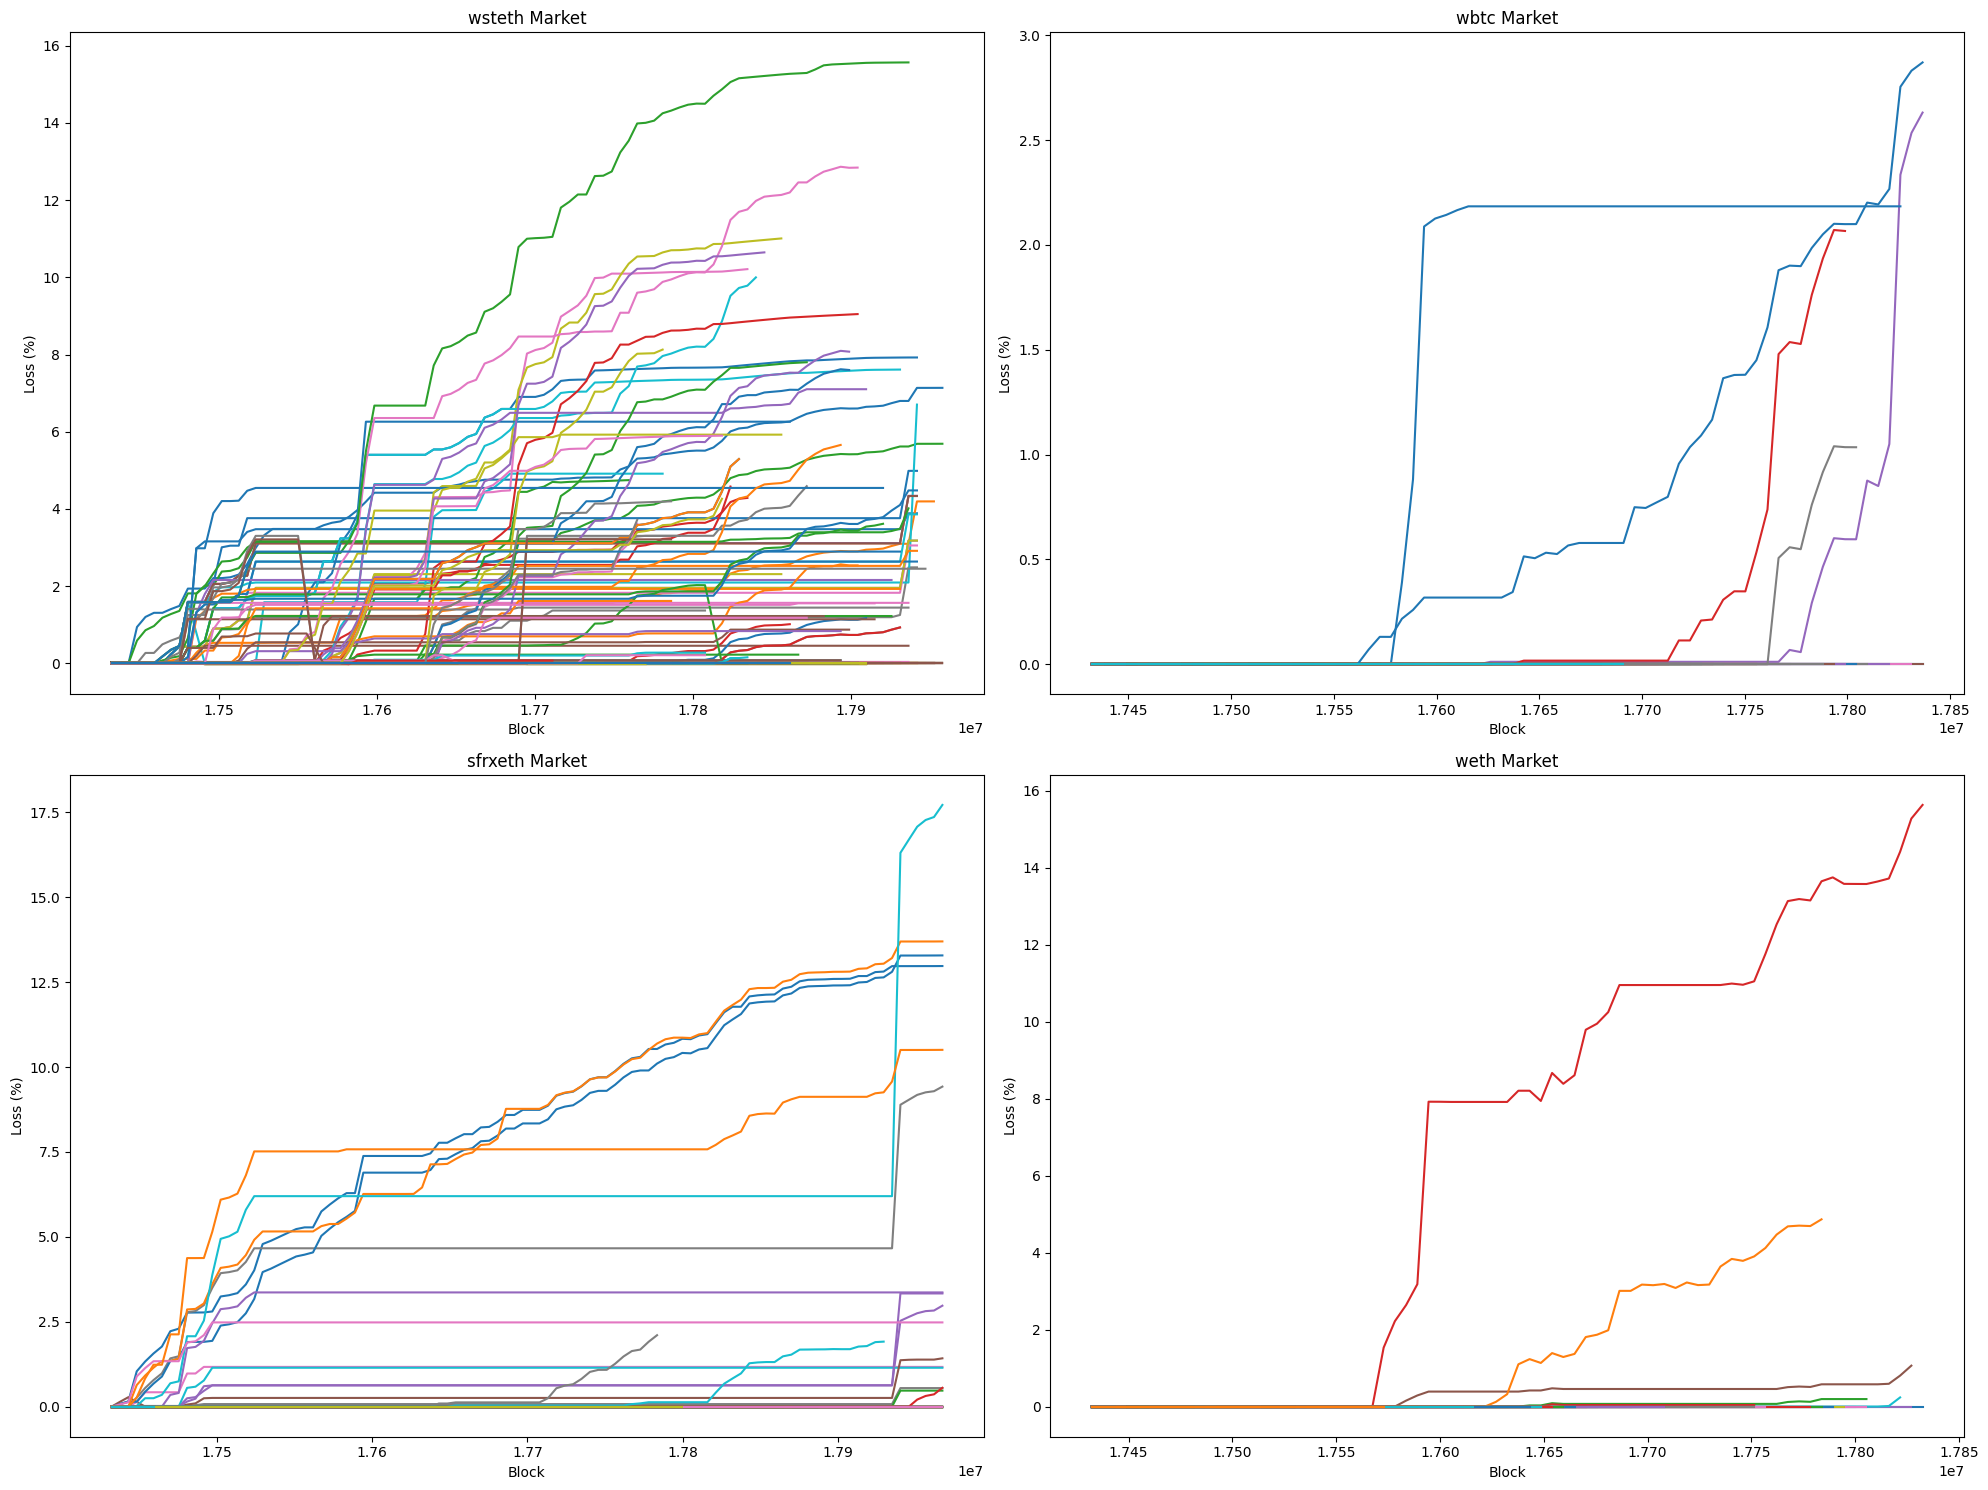

In [16]:
import matplotlib.pyplot as plt

# List of markets
markets = ['wsteth', 'wbtc', 'sfrxeth', 'weth']

# Initialize the figure
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()

# Iterate through the markets
for idx, market in enumerate(markets):
    # Get the DataFrame for the specific market
    market_df = master_df[master_df['Market'] == market]

    # Iterate through the unique users in the market
    for user in market_df['User'].unique():
        # Get the DataFrame for the specific user
        user_df = market_df[market_df['User'] == user]
        
        # Sort the DataFrame by Time
        user_df = user_df.sort_values('Time')

        # Plot the user's health over time
        axs[idx].plot(user_df['Time'], user_df['Loss'])

    # Customize the plot
    axs[idx].set_title(f'{market} Market')
    axs[idx].set_xlabel('Block')
    axs[idx].set_ylabel('Loss (%)')

plt.tight_layout()
plt.show()


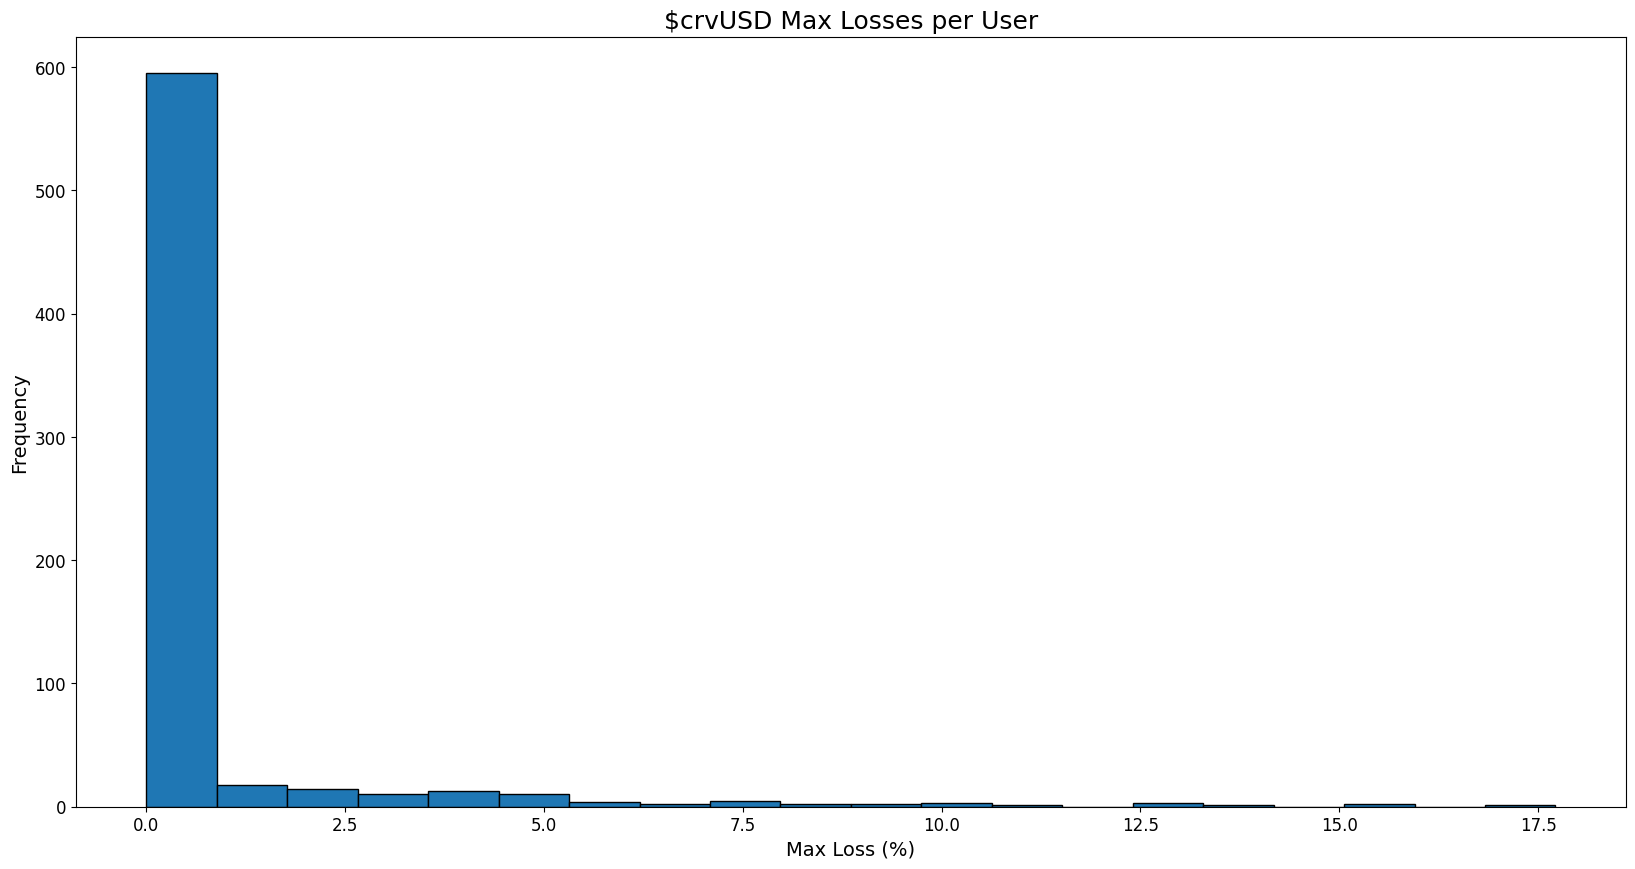

In [17]:
import matplotlib.pyplot as plt

# Get the maximum loss for each user
max_losses_per_user = master_df.groupby('User')['Loss'].max()

# Plotting the histogram for all losses
plt.figure(figsize=(20,10))
plt.hist(max_losses_per_user, bins=20, edgecolor='black')
plt.title('$crvUSD Max Losses per User', fontsize=18)
plt.xlabel('Max Loss (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)                             
plt.yticks(fontsize=12)   
plt.show()


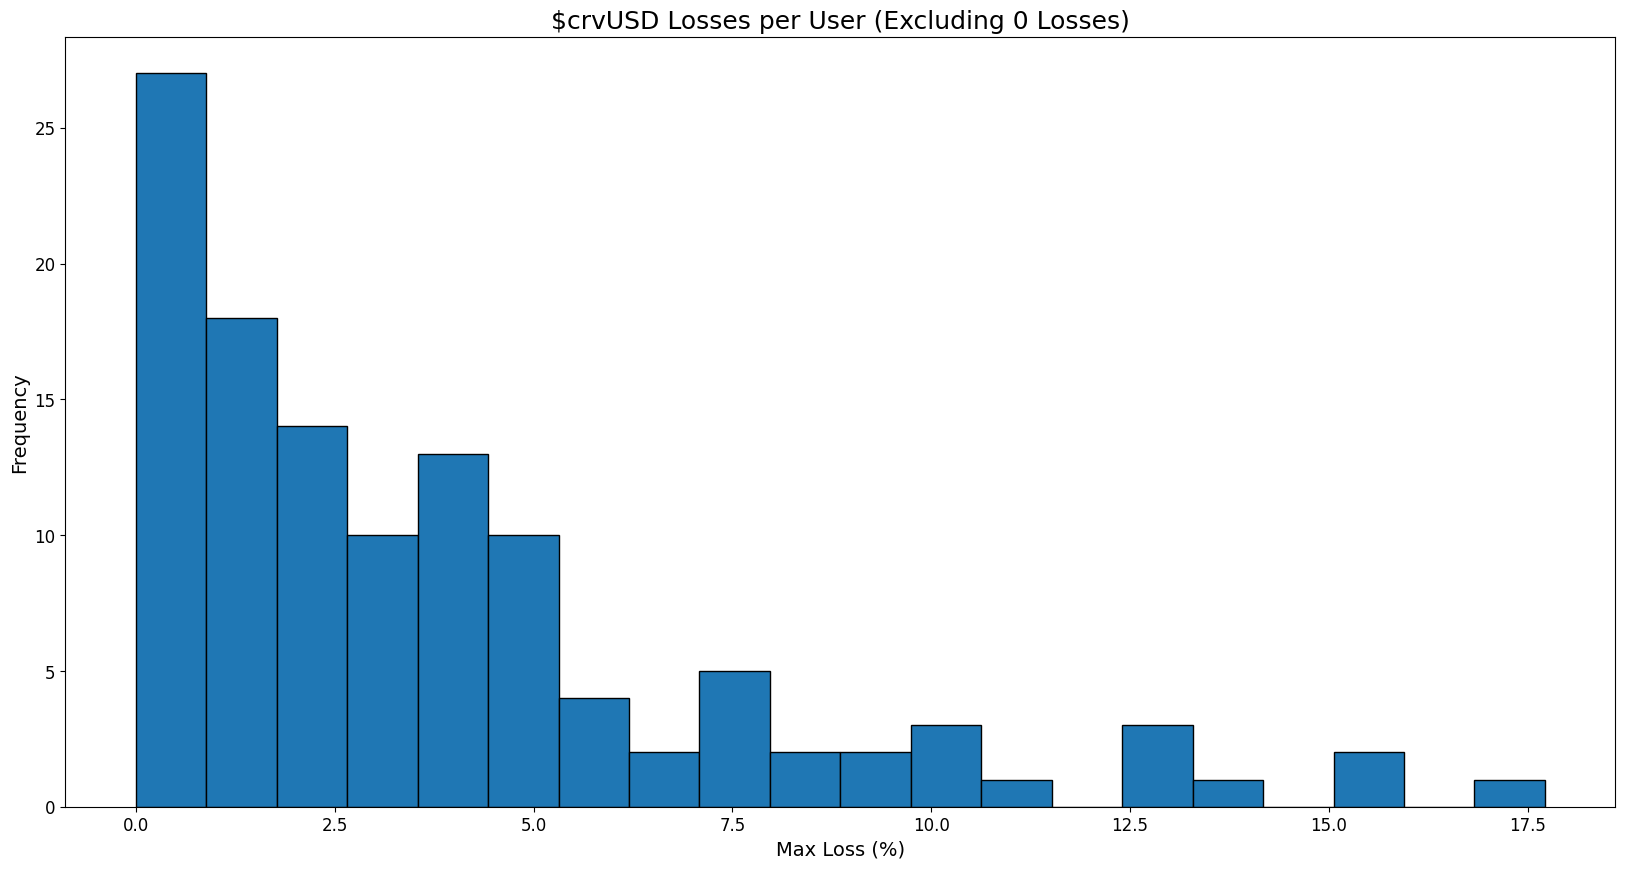

In [18]:

# Filter to exclude users with 0 losses
max_losses_per_user_non_zero = max_losses_per_user[max_losses_per_user > 0]

# Plotting the histogram for non-zero losses
plt.figure(figsize=(20,10))
plt.hist(max_losses_per_user_non_zero, bins=20, edgecolor='black')
plt.title('$crvUSD Losses per User (Excluding 0 Losses)', fontsize=18)
plt.xlabel('Max Loss (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)                             
plt.yticks(fontsize=12)   
plt.show()


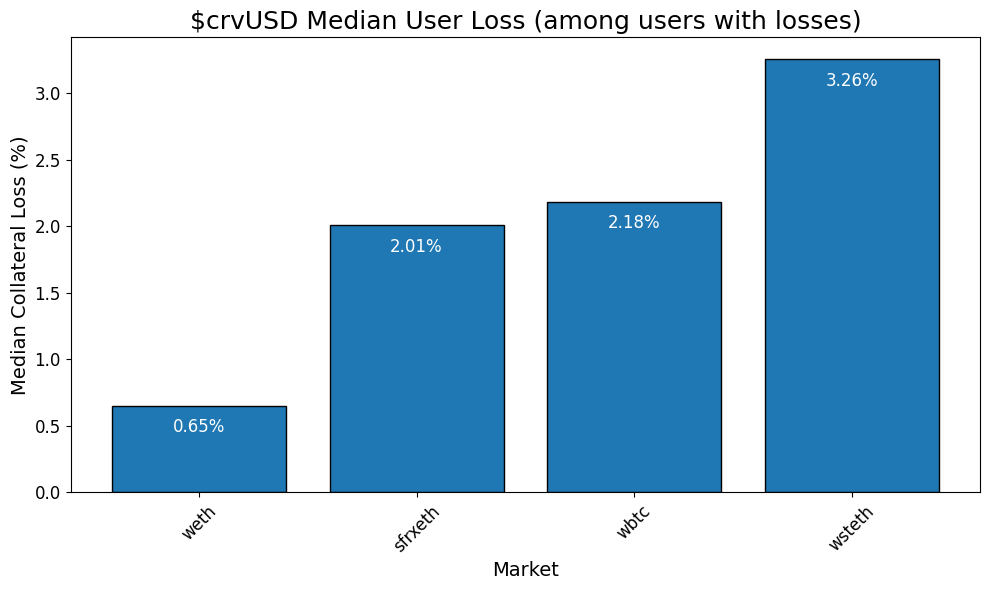

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to calculate the max loss (excluding zero losses)
def max_nonzero_loss(losses):
    nonzero_losses = losses[losses > 0]
    if len(nonzero_losses) > 0:
        return max(nonzero_losses)
    return None

# Group the DataFrame by users and markets, then apply the custom function to the 'Loss' column
max_loss_per_user = master_df.groupby(['User', 'Market'])['Loss'].apply(max_nonzero_loss).reset_index()

# Drop NaN values (users with zero losses only)
max_loss_per_user.dropna(inplace=True)

# Compute the median max loss per market
median_loss_per_market = max_loss_per_user.groupby('Market')['Loss'].median().reset_index().sort_values('Loss')

# Plot the result as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(median_loss_per_market['Market'], median_loss_per_market['Loss'], edgecolor='black')

# Adding data labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.2, f"{round(yval, 2)}%", ha='center', color='white', fontsize=12)

plt.title('$crvUSD Median User Loss (among users with losses)', fontsize=18)
plt.xlabel('Market', fontsize=14)
plt.ylabel('Median Collateral Loss (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [21]:
# Filter users with non-zero losses
non_zero_loss_df = master_df[master_df['Loss'] > 0]

# Calculate the global median loss among these users
global_median_loss = non_zero_loss_df['Loss'].median()

print(f"The global median loss among users with non-zero losses is {global_median_loss:.2f}%")


The global median loss among users with non-zero losses is 2.07%


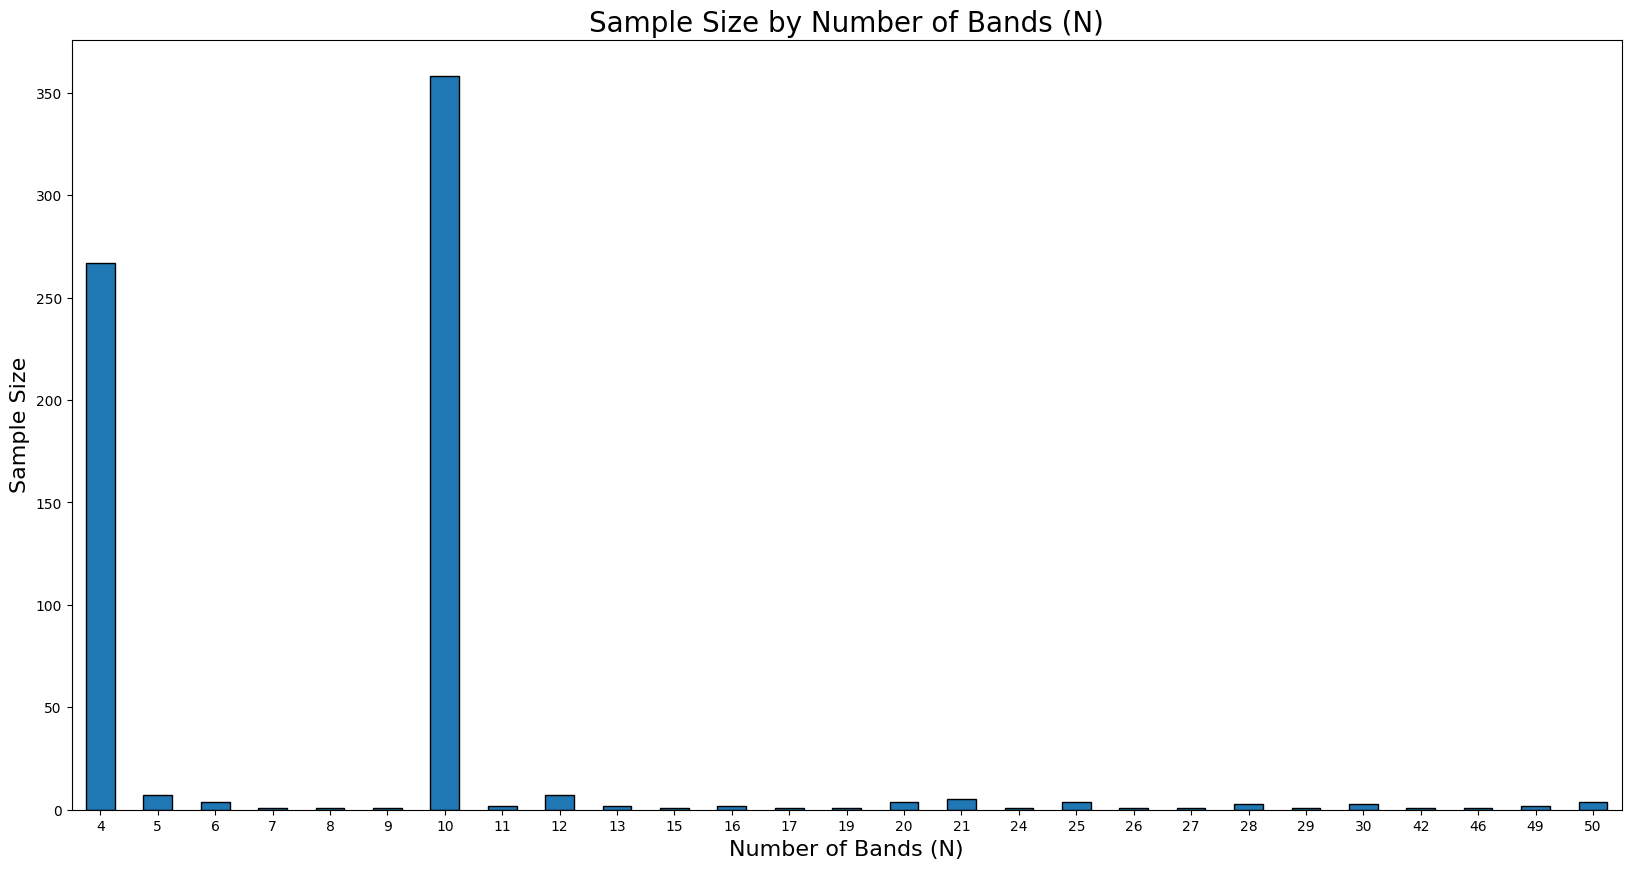

In [20]:
# Get the row with the max loss for each user
max_loss_df = master_df.loc[master_df.groupby('User')['Loss'].idxmax()]

# Filter out rows with zero losses
max_loss_non_zero_df = max_loss_df[max_loss_df['Loss'] > 0]
max_loss_non_zero_df = max_loss_df

# Group by 'N' and calculate the sample size
sample_size_per_N = max_loss_non_zero_df.groupby('N').size()

# Plot the sample size as a bar plot
sample_size_per_N.plot(kind='bar', edgecolor='black', figsize=(20,10))
#plt.figure(figsize=(20,10))
plt.title('Sample Size by Number of Bands (N)', fontsize=20)
plt.xlabel('Number of Bands (N)', fontsize=16)
plt.ylabel('Sample Size', fontsize=16)
plt.xticks(rotation=0)

plt.show()


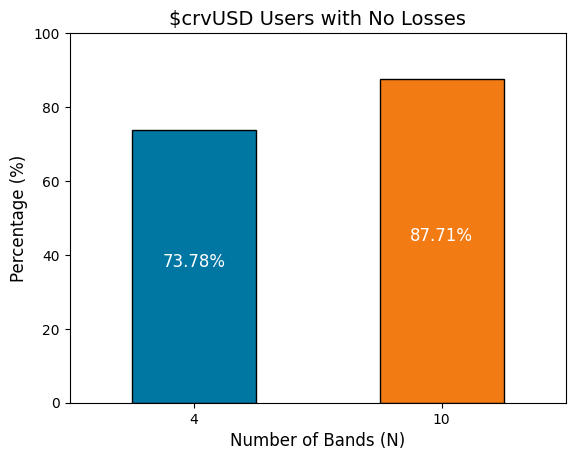

In [22]:
# Filter rows with 'N' equal to 4 or 10
bands_df = max_loss_df[max_loss_df['N'].isin([4, 10])]

# Calculate the number of users with max loss of 0 for each 'N'
zero_loss_count = bands_df[bands_df['Loss'] == 0].groupby('N').size()

# Calculate the total number of users for each 'N'
total_count = bands_df.groupby('N').size()

# Calculate the percentage of users with max loss of 0 for each 'N'
zero_loss_percentage = (zero_loss_count / total_count) * 100

# Plot the bar chart
ax = zero_loss_percentage.plot(kind='bar', edgecolor='black', color=['#0076a3','#f37b13'])
plt.title('$crvUSD Users with No Losses', fontsize=14)
plt.xlabel('Number of Bands (N)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 100)  # To set y-axis limits from 0 to 100

# Add the text overlay
for i, v in enumerate(zero_loss_percentage):
    ax.text(i, v/2, f'{v:.2f}%', color='white', ha='center', fontsize=12)

plt.show()


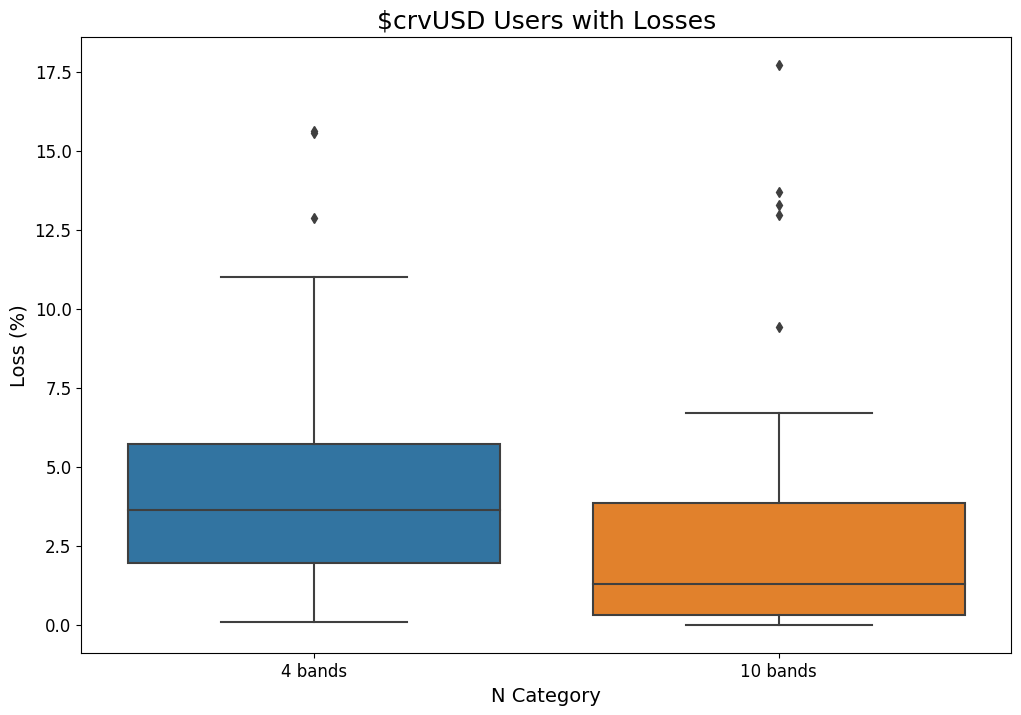

In [24]:
import pandas as pd
import seaborn as sns

# Extract the data for N=4 and N=10 and create the category column
user_df_4 = master_df[master_df['Loss'] > 0]
user_df_4 = user_df_4[user_df_4['N'] == 4].groupby('User')['Loss'].max().reset_index()
user_df_4['Band'] = '4 bands'

user_df_10 = master_df[master_df['Loss'] > 0]
user_df_10 = user_df_10[user_df_10['N'] == 10].groupby('User')['Loss'].max().reset_index()
user_df_10['Band'] = '10 bands'

# Concatenate the data
combined_df = pd.concat([user_df_4, user_df_10], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Band", y="Loss", data=combined_df)
plt.title('$crvUSD Users with Losses', fontsize=18)
plt.xlabel('N Category', fontsize=14)
plt.ylabel('Loss (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()




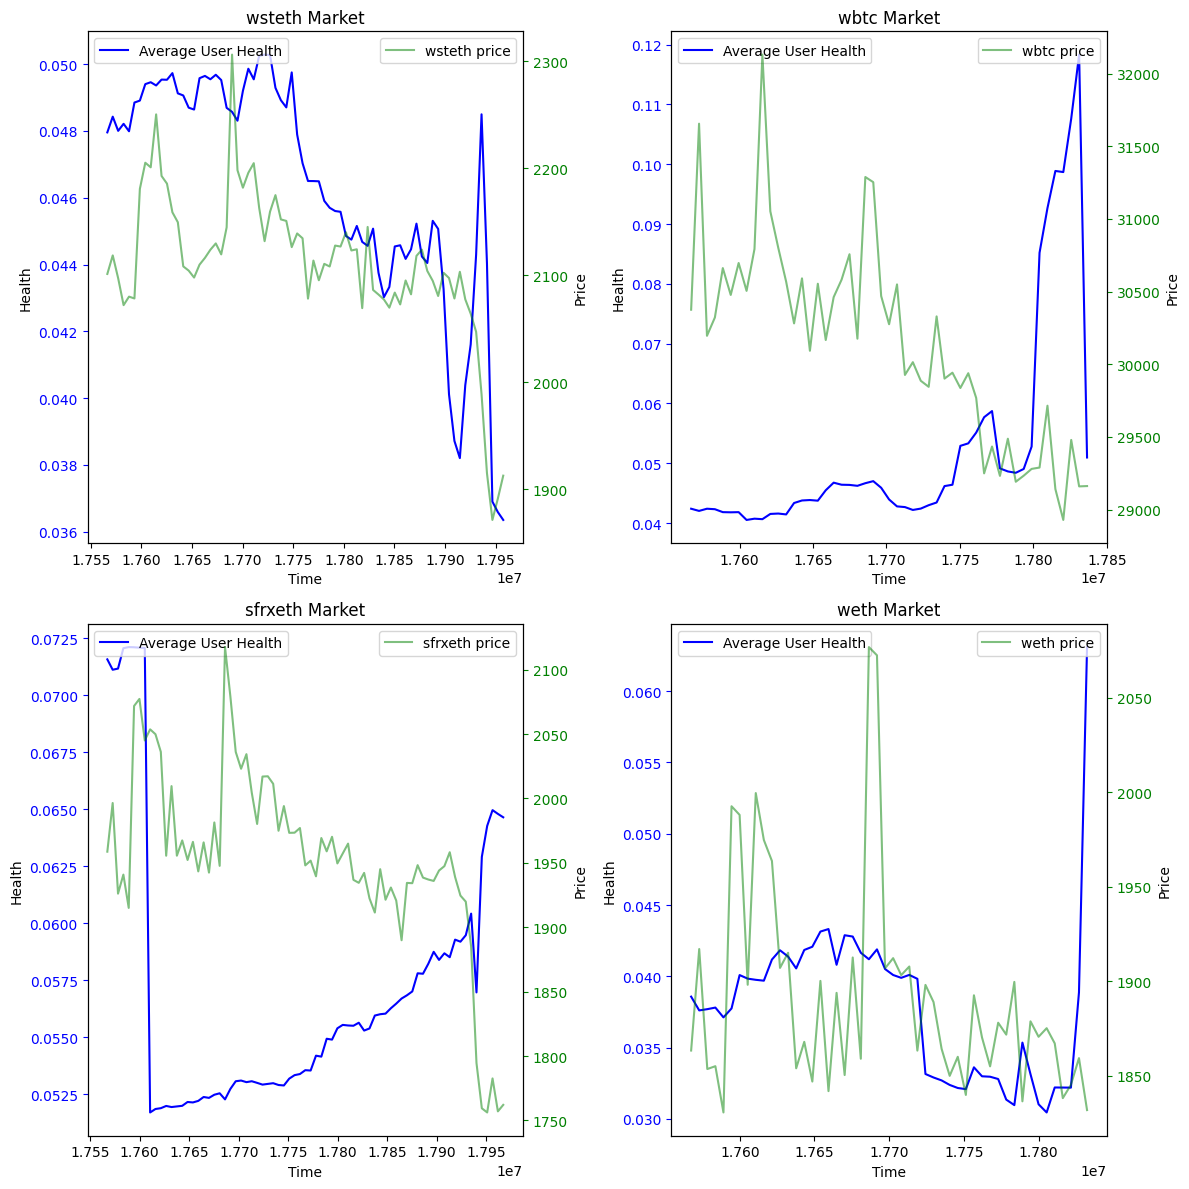

In [26]:
# Dictionary to store average health for each market and timestamp
avg_health_dict = {}

# Iterating through the unique markets
for market in master_df['Market'].unique():
    market_df = master_df[master_df['Market'] == market]
    
    # Iterating through the unique timestamps
    for timestamp in market_df['Time'].unique():
        timestamp_df = market_df[market_df['Time'] == timestamp]
        
        # Calculate the average health at the specific timestamp
        avg_health = timestamp_df['Health'].mean()
        median_health = timestamp_df['Health'].median()
        
        # Storing average health in the dictionary
        avg_health_dict[(market, timestamp)] = avg_health

# Function to apply average health to master_df
def apply_avg_health(row):
    return avg_health_dict.get((row['Market'], row['Time']), None)

# Applying average health to master_df
master_df['AvgHealth'] = master_df.apply(apply_avg_health, axis=1)


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over the markets and their respective axes
markets = ['wsteth', 'wbtc', 'sfrxeth', 'weth']
for market, ax in zip(markets, axs.flatten()):
    # Extract the market's price
    market_price = master_df[master_df['Market'] == market].sort_values('Time').dropna()  # Sorting by 'Time'

    # Assuming 'SoftLiqPct' is the column with the percentage of users who have a loss
    percentage_loss = market_price['AvgHealth']

    ax.plot(market_price['Time'], percentage_loss, color='blue', label='Average User Health')

    # Create a second y-axis
    ax2 = ax.twinx()
    # Plot the market's price as a line
    ax2.plot(market_price['Time'], market_price[market+'_price'], color='green', alpha=0.5, label=f'{market} price')

    # Customize the plot
    ax.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax.set_ylabel('Health')
    
    ax.set_title(f'{market} Market')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='green')

# Show the plots
plt.tight_layout()
plt.show()


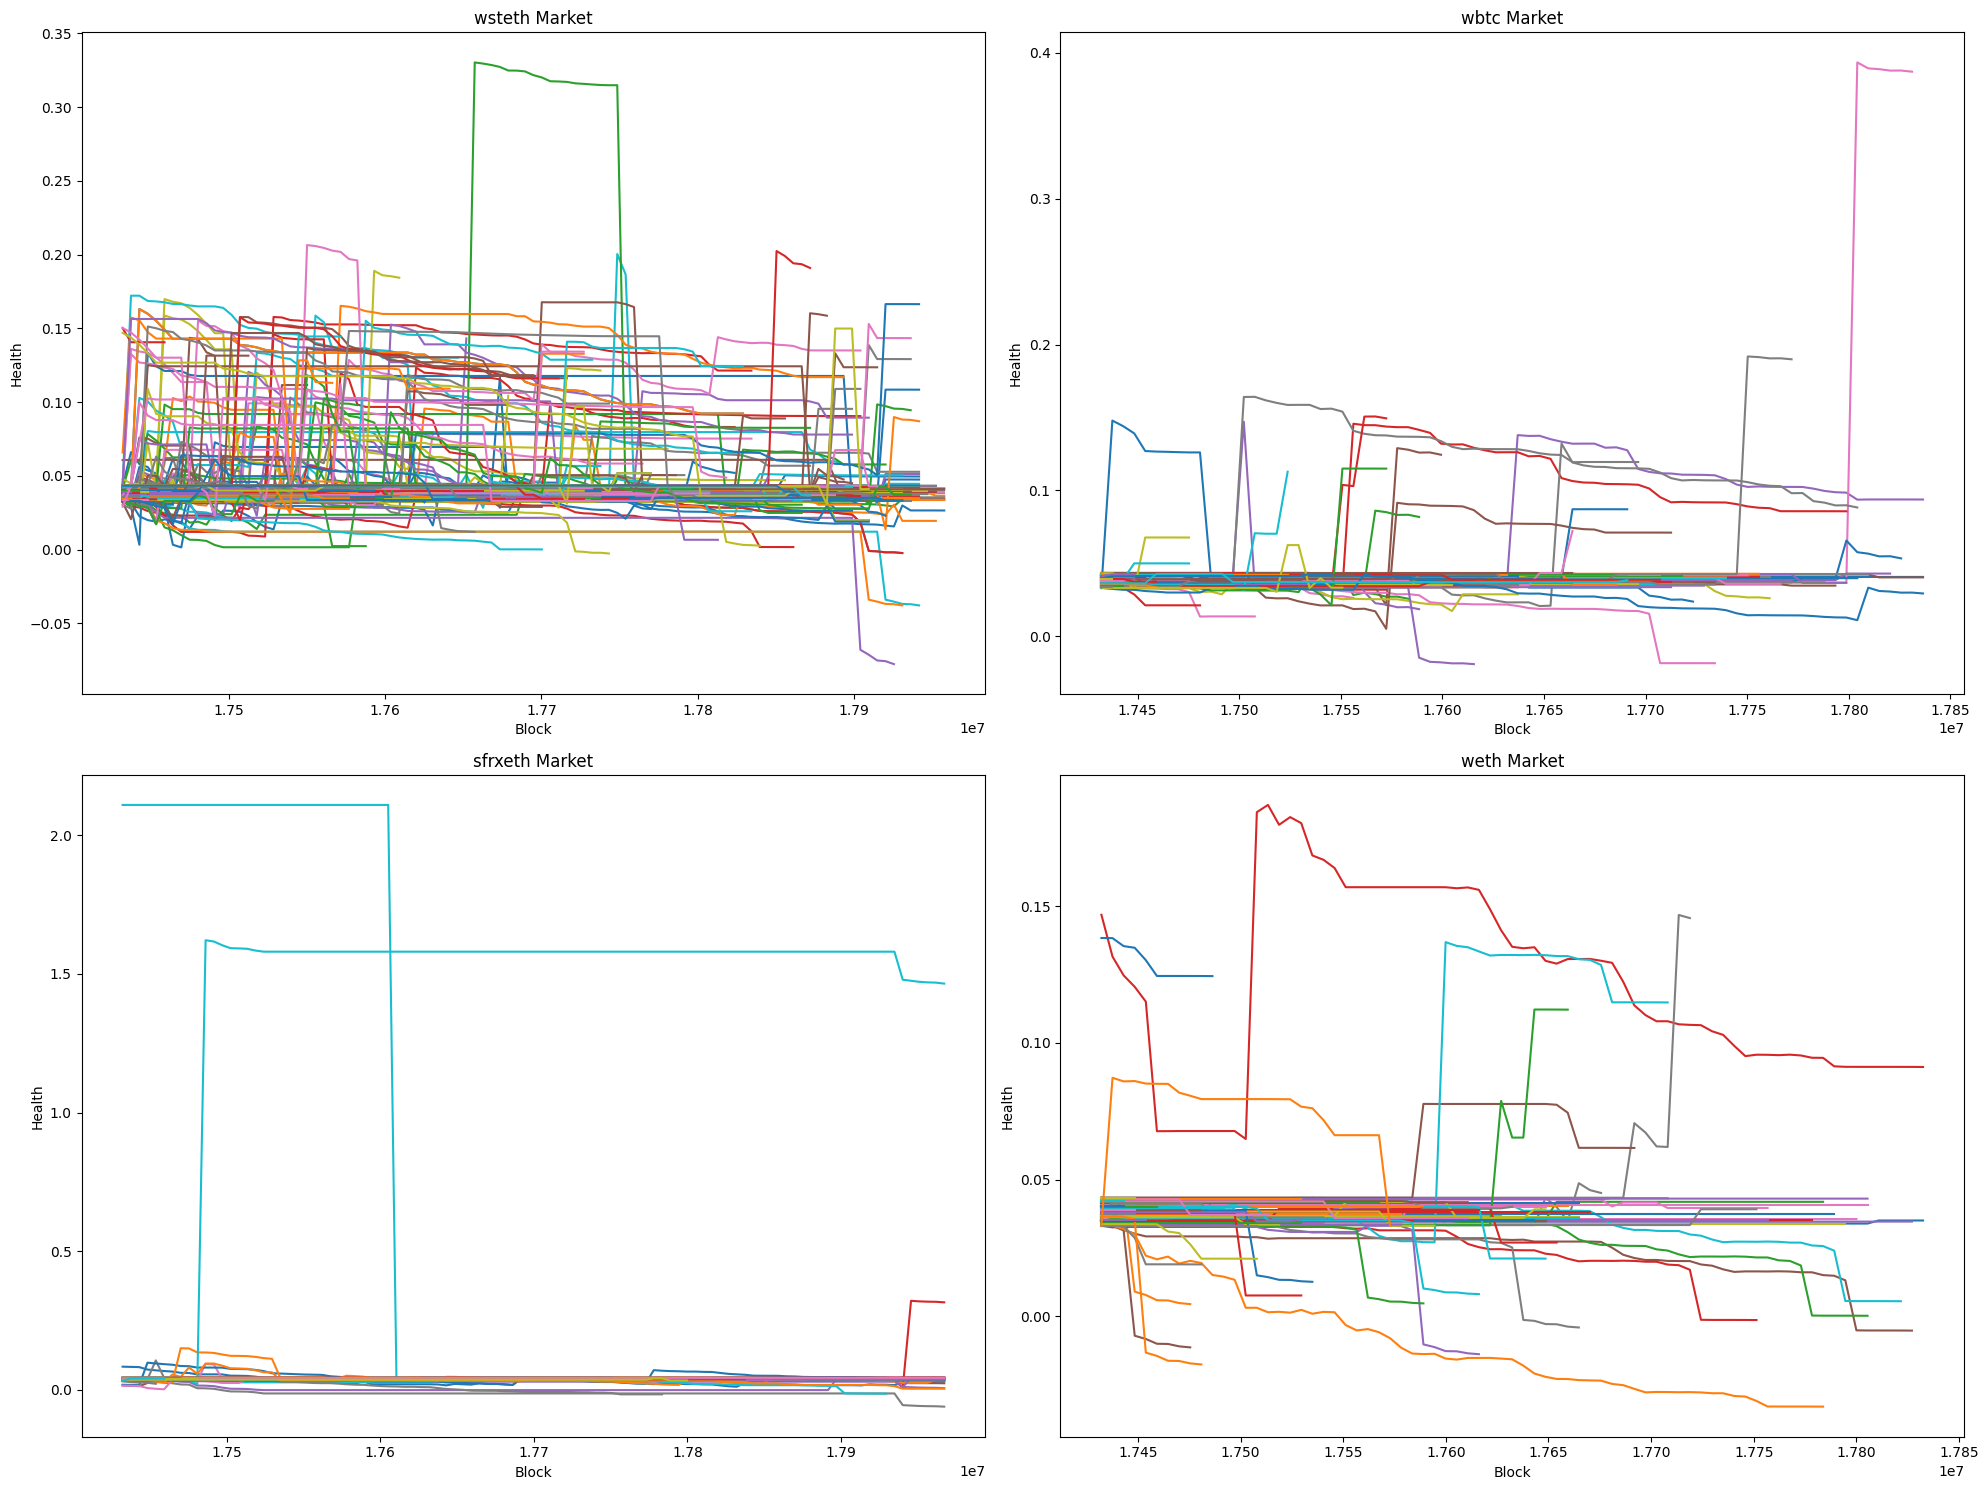

In [27]:
import matplotlib.pyplot as plt

# List of markets
markets = ['wsteth', 'wbtc', 'sfrxeth', 'weth']

# Initialize the figure
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()

# Iterate through the markets
for idx, market in enumerate(markets):
    # Get the DataFrame for the specific market
    market_df = master_df[master_df['Market'] == market]

    # Iterate through the unique users in the market
    for user in market_df['User'].unique():
        # Get the DataFrame for the specific user
        user_df = market_df[market_df['User'] == user]
        
        # Sort the DataFrame by Time
        user_df = user_df.sort_values('Time')

        # Plot the user's health over time
        axs[idx].plot(user_df['Time'], user_df['Health'])

    # Customize the plot
    axs[idx].set_title(f'{market} Market')
    axs[idx].set_xlabel('Block')
    axs[idx].set_ylabel('Health')

plt.tight_layout()
plt.show()
